<h1 style="font-size:40px; color:#2832c2; font-weight:600">Emotion Detection using <span style="color:darkorange">VGG16</span>, <span style="color:darkorange">InceptionV3</span>
</h1>

<a id="contents_tabel"></a>

## 📚 Table of Content
<br>

<span style="font-size: 1.2em;line-height:1.3em">
    
- **[1 | Setting up Kaggle Directory](#1)**   
- **[2 | Import Libraries](#2)**
- **[3 | Dataset Analysis](#3)**
    - **[3.1 | Accept specific img formats](#3.1)**
    - **[3.2 | Categories Distribution](#3.2)**
    - **[3.3 | Image Dimension Analysis](#3.3)**
    - **[3.4 | Plot Images from Categories](#3.4)**
- **[4 | Centralizing Dataset Information](#4)**
- **[5 | Data Splitting into Training & Validation Sets](#5)**
- **[6 | Data Augmentation & Preprocessing](#6)**
- **[7 | Custom Model Architecture Development](#7)**    
    - **[7.1 | Model Training](#7.1)**'
    - **[7.2 | Model Performance Assessment](#7.2)**
- **[8 | VGG16 Model Architecture Development](#8)**    
    - **[8.1 | Model Training leveraging pre-trained weights](#8.1)**'
    - **[8.2 | Model Performance Assessment](#8.2)**
- **[9 | InceptionV3 Model Architecture Development](#9)**    
    - **[9.1 | Model Training leveraging pre-trained weights](#9.1)**'
    - **[9.2 | Model Performance Assessment](#9.2)**
- **[10 | Conclusion](#10)**    


 <div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    <h3>DataSet Overview</h3>

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.
<h3>🎯 Objective</h3>
    
The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


<a id="1"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">1 | Setting up Kaggle Directory</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [1]:
# !pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

<a id="2"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">2 | Import Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [5]:
# !pip install tensorflow==2.15.0
# !pip install pydot
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

import warnings
# Ignore all FutureWarnings temporarily
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input

2024-06-19 10:21:44.029226: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 10:21:44.173461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 10:21:44.173632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 10:21:44.192671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 10:21:44.248015: I tensorflow/core/platform/cpu_feature_guar

<a id="3"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">3 | Dataset Analysis</p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="3.1"></a>
# <b><span style='color:#2832c2'>3.1 | </span><span style='color:darkorange'>Accept specific img formats</span></b>

In [6]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

<a id="3.2"></a>
# <b><span style='color:#2832c2'>3.2 | </span><span style='color:darkorange'>Categories Distribution</span></b>

 <div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    Firstly, I'll begin by conducting an initial analysis to explore the class distribution within the dataset:

In [7]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  neutral  angry  surprise  disgust  fear  happy
train  4830     4965   3995      3171      436  4097   7215
       sad  neutral  angry  surprise  disgust  fear  happy
test  1247     1233    958       831      111  1024   1774


<Axes: >

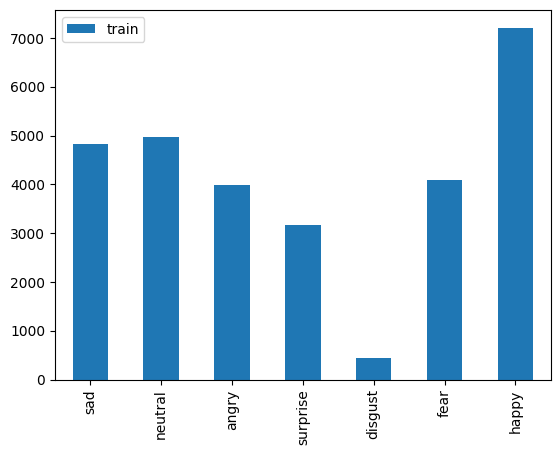

In [8]:
train_count.transpose().plot(kind='bar')

<Axes: >

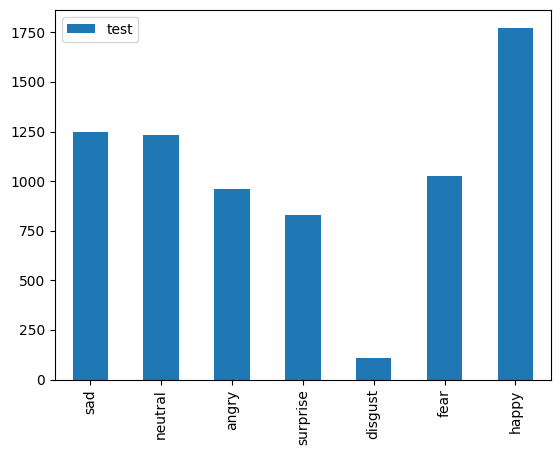

In [9]:
test_count.transpose().plot(kind='bar')

 <div style="background-color:#f5deb3; padding:12px;border-radius:12px">
    <p>The provided plot illustrates, that categories like "happy", "sad", "neutral" shows higher distribution compared to others</p>

<a id="3.3"></a>
# <b><span style='color:#2832c2'>3.3 | </span><span style='color:darkorange'>Image Dimension Analysis</span></b>

In [10]:
# Lists to store heights and widths of all images
heights = []
widths = []

# Initialize a set to store unique dimensions and channels
unique_dims = set()
unique_channels = set()

# Function to process images in a directory
def process_images(base_path):
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                img_path = os.path.join(category_path, filename)
                # print(f"Processing: {img_path}")  # Debug print
                img = cv2.imread(img_path)
                if img is not None:
                    # Add the dimensions (height, width, channels) to the set
                    unique_dims.add((img.shape[0], img.shape[1]))

                    # Add the channels to the set
                    unique_channels.add(img.shape[2])

                    # Append heights and widths for statistical calculations
                    heights.append(img.shape[0])
                    widths.append(img.shape[1])
                else:
                    print(f"Could not read image: {img_path}")  # Debug print

# Process images in both 'train' and 'test' directories
process_images(train_dir)
process_images(test_dir)

# Check if all images have the same dimension
if len(unique_dims) == 1:
    print(f"All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f"There are {len(unique_dims)} different image dimensions in the dataset.")
    if heights and widths:  # Ensure lists are not empty before calculating min, max, mean
        print(f"Min height: {min(heights)}, Max height: {max(heights)}, Mean height: {np.mean(heights):.2f}")
        print(f"Min width: {min(widths)}, Max width: {max(widths)}, Mean width: {np.mean(widths):.2f}")

# Check if all images have the same number of channels
if len(unique_channels) == 1:
    channel = list(unique_channels)[0]
    if channel == 3:
        print("All images are color images.")
    else:
        print("All images have the same number of channels, but they are not color images.")
else:
    print("Images have different numbers of channels.")

All images have the same dimensions: (48, 48)
All images are color images.


 <div style="background-color:#f5deb3; padding:12px;border-radius:12px">
<p>
The dataset showcases a same array of image sizes, with same dimensions . all images are consistently in color.</p>

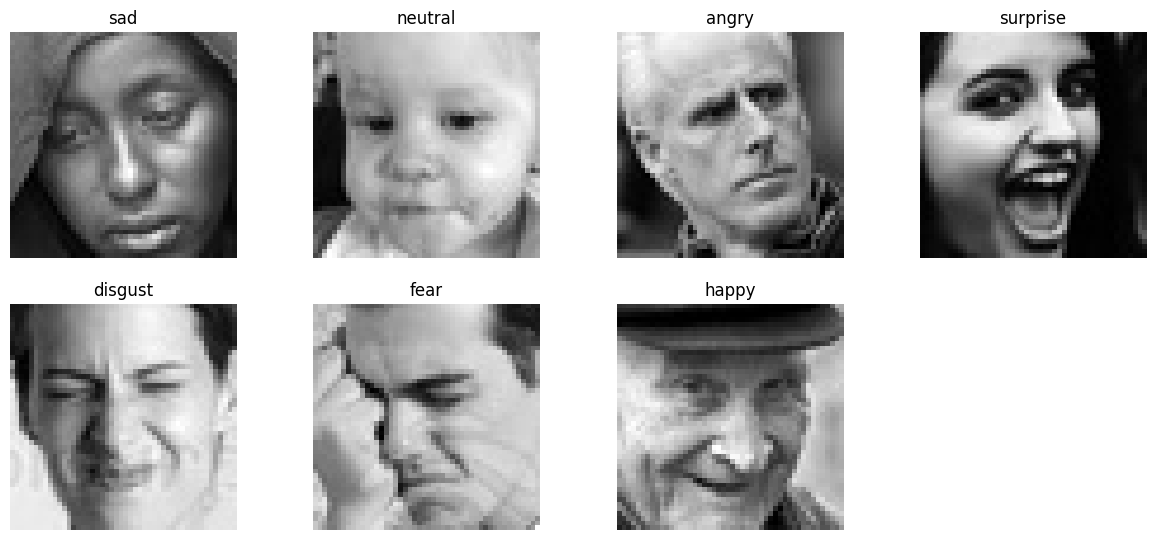

In [11]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[5])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

<a id="3.4"></a>
# <b><span style='color:#2832c2'>3.4 | </span><span style='color:darkorange'>Plot Images from Categories</span></b>

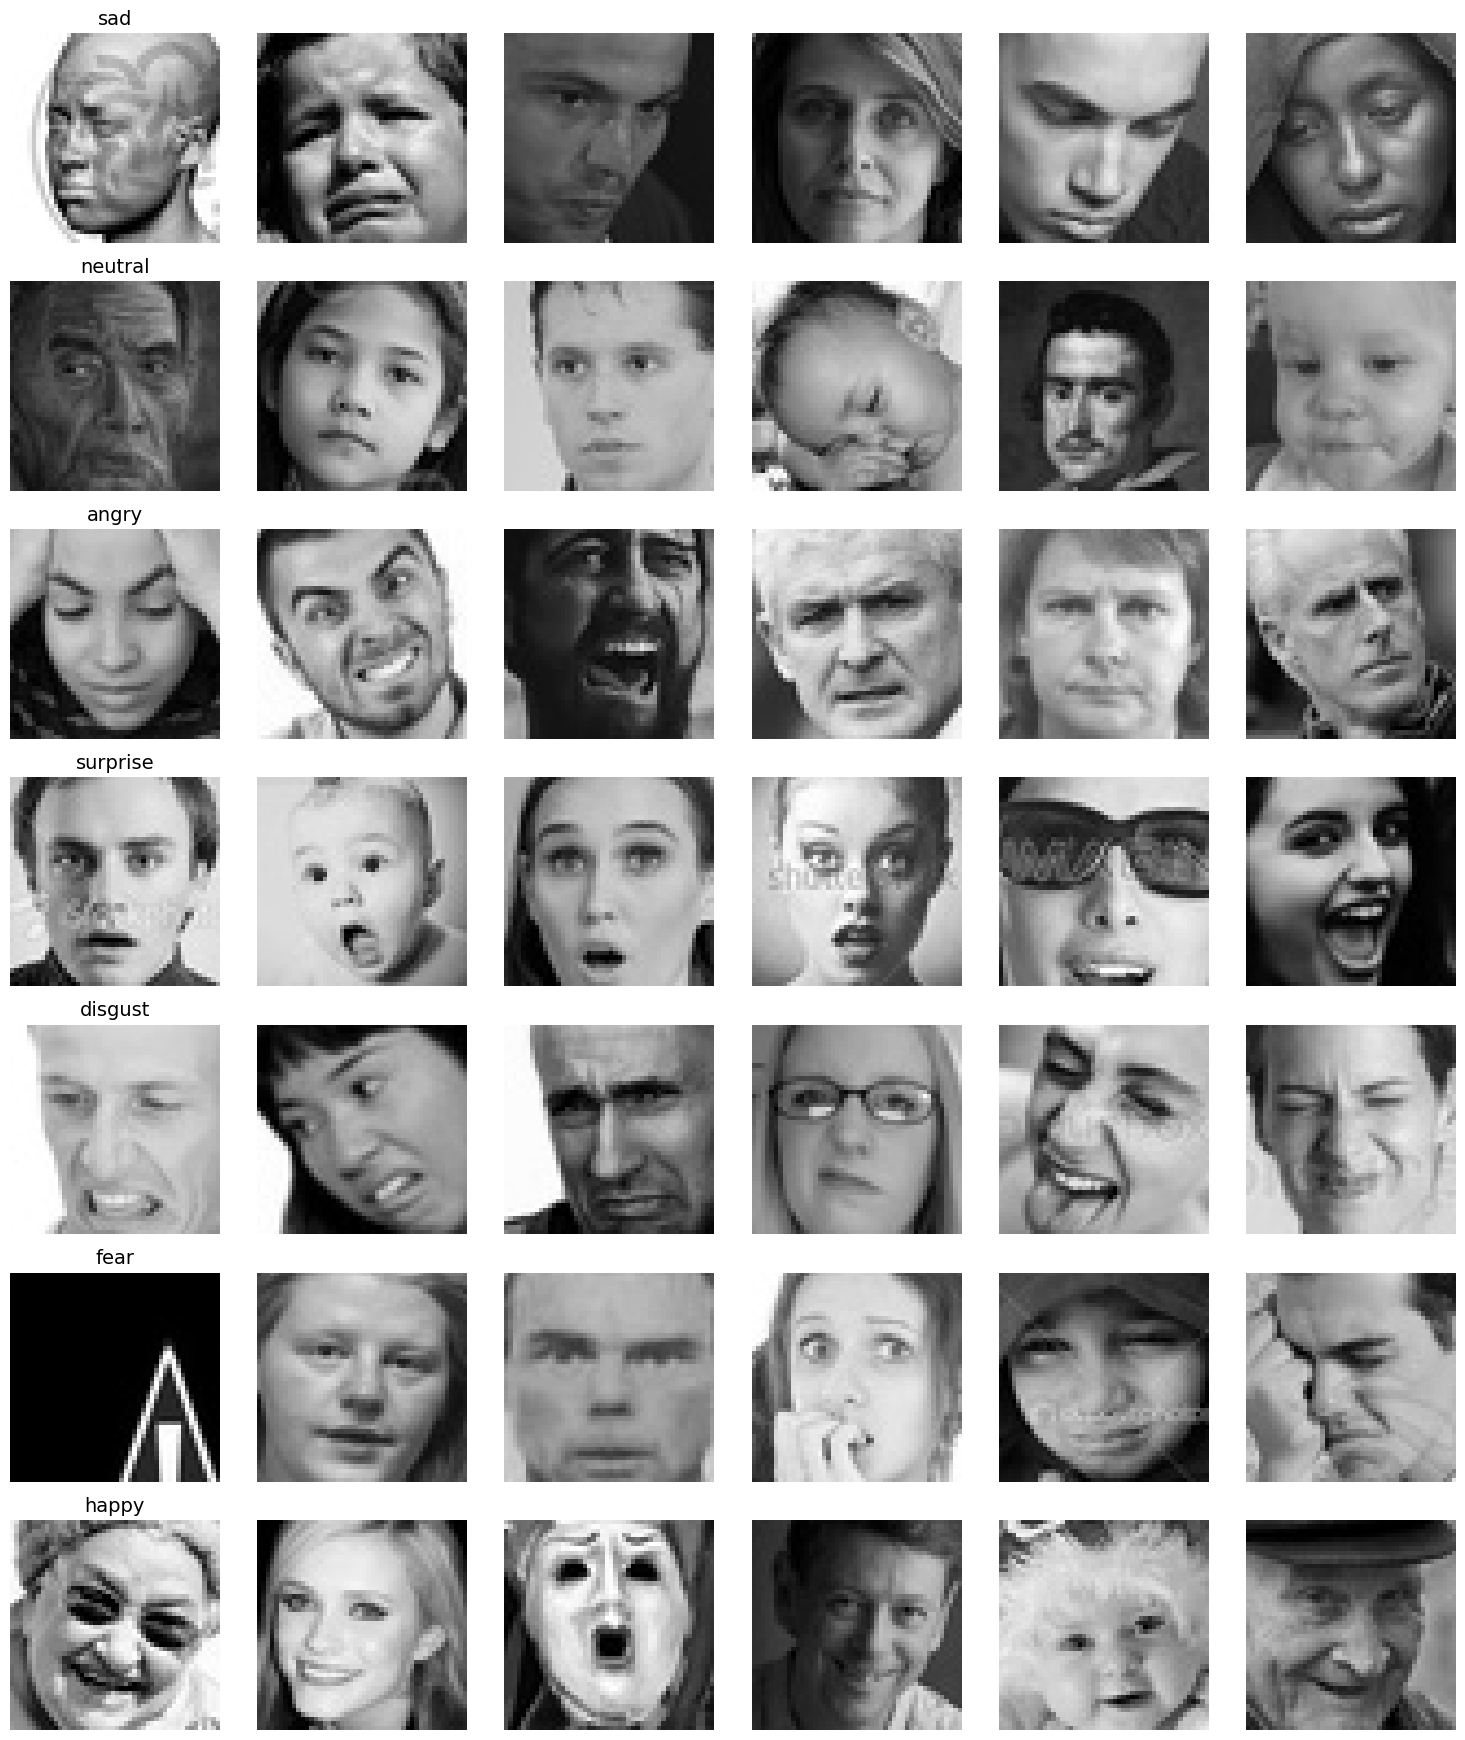

In [12]:
def plot_images_from_categories(base_dir, num_images=6):
    """
    Plots a specified number of images from each category in the base directory.

    Parameters:
    - base_dir: str, the base directory containing category subdirectories.
    - num_images: int, the number of images to display from each category.

    """
    categories = os.listdir(base_dir)
    num_categories = len(categories)

    # Calculate the grid size
    fig, axes = plt.subplots(num_categories, num_images, figsize=(15, num_categories * 2.5))

    for cat_idx, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        img_files = os.listdir(category_path)

        for img_idx in range(num_images):
            if img_idx < len(img_files):
                img_path = os.path.join(category_path, img_files[img_idx])
                img = cv2.imread(img_path)
                if img is not None:
                    # Convert BGR to RGB
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    axes[cat_idx, img_idx].imshow(img_rgb)
                else:
                    axes[cat_idx, img_idx].text(0.5, 0.5, 'Error', fontsize=12, ha='center')
            else:
                axes[cat_idx, img_idx].text(0.5, 0.5, 'No Image', fontsize=12, ha='center')

            axes[cat_idx, img_idx].axis('off')
            if img_idx == 0:
                axes[cat_idx, img_idx].set_title(category, fontsize=14)

    plt.tight_layout()
    plt.show()


plot_images_from_categories(train_dir)


<a id="4"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">4 | Centralizing Dataset Information</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [13]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Process the train directory
train_categories = os.listdir(train_dir)
for category in train_categories:
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):  # Check if it's a directory
        data.extend([(os.path.join(category_path, filename), category, "train") for filename in os.listdir(category_path)])

# Process the test directory
test_categories = os.listdir(test_dir)
for category in test_categories:
    category_path = os.path.join(test_dir, category)
    if os.path.isdir(category_path):  # Check if it's a directory
        data.extend([(os.path.join(category_path, filename), category, "test") for filename in os.listdir(category_path)])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'category', 'set'])

# Display the first few entries of the DataFrame
df.head()

filepath category    set
0  /content/train/sad/Training_87663300.jpg      sad  train
1  /content/train/sad/Training_13323545.jpg      sad  train
2  /content/train/sad/Training_18722044.jpg      sad  train
3  /content/train/sad/Training_22095016.jpg      sad  train
4  /content/train/sad/Training_39763836.jpg      sad  train

In [14]:
df.shape

(35887, 3)

In [15]:
# Deleting unnecessary variables to free up memory
del heights, widths, unique_dims, unique_channels, data


<a id="5"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">5 | Data Splitting into Training & Validation Sets</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [16]:
# Separate the data into train_df and val_df based on the "set" column
train_df = df[df['set'] == 'train'].reset_index(drop=True).drop(columns=['set'])
val_df = df[df['set'] == 'test'].reset_index(drop=True).drop(columns=['set'])

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (28709, 2)
Validation data shape: (7178, 2)


In [17]:
train_df.head()

filepath category
0  /content/train/sad/Training_87663300.jpg      sad
1  /content/train/sad/Training_13323545.jpg      sad
2  /content/train/sad/Training_18722044.jpg      sad
3  /content/train/sad/Training_22095016.jpg      sad
4  /content/train/sad/Training_39763836.jpg      sad

In [18]:
# Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

In [19]:
train_df.head()

filepath category
0  /content/train/neutral/Training_77312934.jpg  neutral
1    /content/train/happy/Training_19487387.jpg    happy
2     /content/train/fear/Training_12246633.jpg     fear
3    /content/train/angry/Training_91001054.jpg    angry
4    /content/train/angry/Training_81569305.jpg    angry


<a id="6"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">6 | Data Augmentation & Preprocessing</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [20]:
def create_data_generators(train_df, val_df, filepath_column='filepath', label_column='category',
                           color_mode='grayscale',
                           preprocessing_function=None, batch_size=32, image_dimensions=(48, 48)):
    """
    Creates and returns training and validation data generators with optional preprocessing.

    Parameters:
    - train_df (DataFrame): DataFrame containing training data.
    - val_df (DataFrame): DataFrame containing validation data.
    - filepath_column (str, optional): Name of the column in DataFrame containing file paths. Defaults to 'filepath'.
    - label_column (str, optional): Name of the column in DataFrame containing labels. Defaults to 'category'.
    - preprocessing_function (function, optional): Preprocessing function specific to a model. Defaults to None.
    - batch_size (int, optional): Number of images per batch for the generators. Defaults to 32.
    - image_dimensions (tuple, optional): Dimensions to which the images will be resized (height, width). Defaults to (299, 299).

    Returns:
    - train_generator (ImageDataGenerator): Generator for training data with augmentations.
    - val_generator (ImageDataGenerator): Generator for validation data without augmentations.

    Notes:
    - The training generator uses augmentations.
    - The validation generator does not use any augmentations.
    - If provided, the preprocessing function is applied to both generators.
    """

    # Define our training data generator with specific augmentations
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,                             # Randomly rotate the images by up to 15 degrees
        width_shift_range=0.15,                        # Randomly shift images horizontally by up to 15% of the width
        height_shift_range=0.15,                       # Randomly shift images vertically by up to 15% of the height
        zoom_range=0.15,                               # Randomly zoom in or out by up to 15%
        horizontal_flip=True,                          # Randomly flip images horizontally
        vertical_flip=False,                           # Do not flip images vertically as it doesn't make sense in our context
        shear_range=0.02,                              # Apply slight shear transformations
        preprocessing_function=preprocessing_function  # Apply preprocessing function if provided
    )

    # Define our validation data generator without any augmentations but with the preprocessing function if provided
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocessing_function
    )

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col=filepath_column,              # Column with paths to image files
        y_col=label_column,                 # Column with image labels
        target_size=image_dimensions,       # Resize all images to specified dimensions
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify categorical classification task for multi-class labels
        seed=42,                            # Seed for random number generator to ensure reproducibility
        color_mode=color_mode,
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )
    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col=filepath_column,
        y_col=label_column,
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify categorical classification task for multi-class labels
        seed=42,
        color_mode=color_mode,
        shuffle=False                       # Do not shuffle validation data to evaluate on the same data each epoch
    )

    # Return the training and validation generators
    return train_generator, val_generator



<a id="7"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">7 | Custom Model Architecture Development</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [21]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
num_classes = 7

In [22]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

2024-06-19 10:21:51.842714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 10:21:52.015651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-19 10:21:52.015896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [23]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

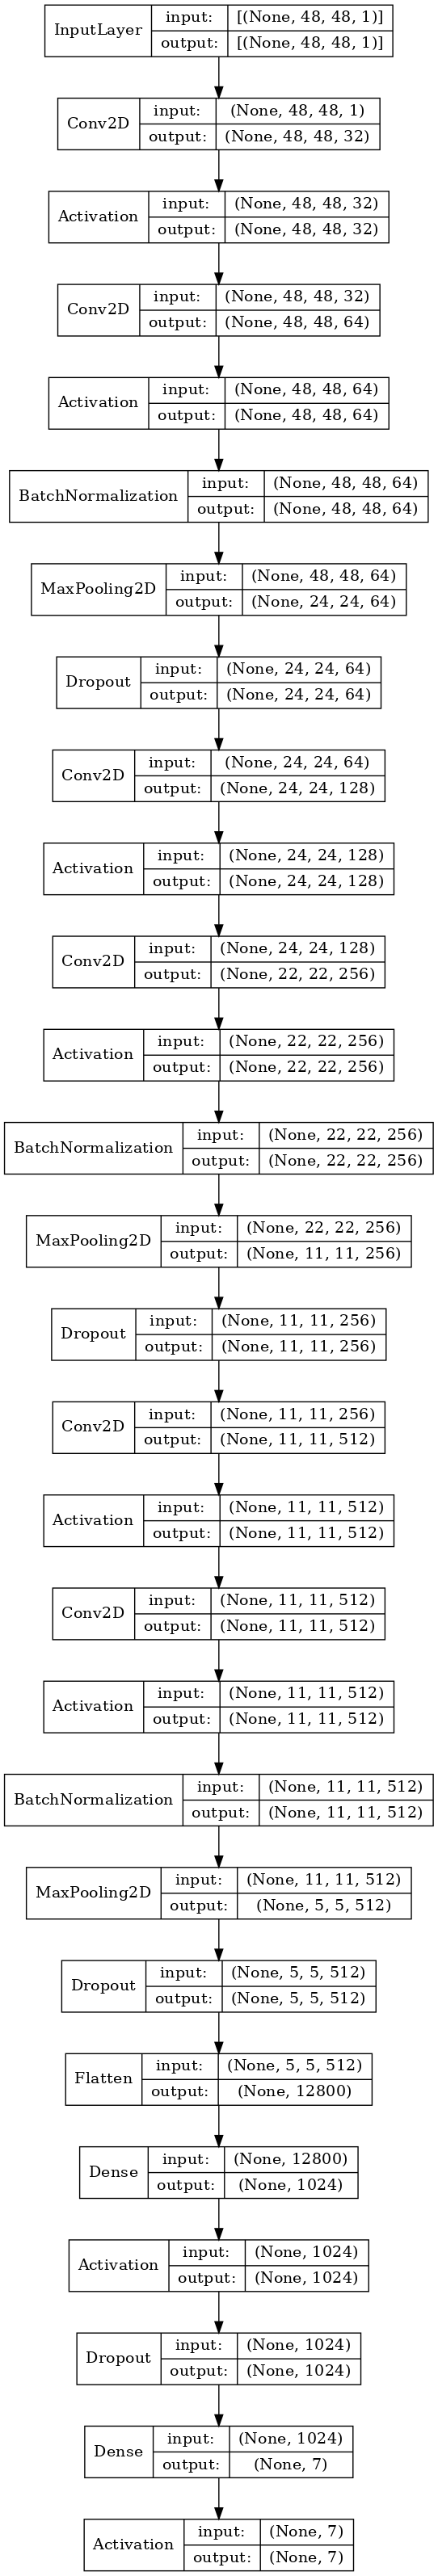

In [24]:
plot_model(model, to_file = 'Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png', show_shapes=True, show_layer_names=False, dpi=100)

<a id="7.1"></a>
# <b><span style='color:#2832c2'>7.1 | </span><span style='color:darkorange'>Model Training</span></b>

In [25]:
# File path for the model checkpoint
cnn_path = '/Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'

chk_path = os.path.join(cnn_path, name)

# Define number of epochs
num_epochs = 10
batch_size = 64
# Create data generators
train_generator, val_generator = create_data_generators(train_df,
                                                        val_df,
                                                        batch_size=32,
                                                        image_dimensions=(48, 48))

# Define the callbacks
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath='Custom_CNN_model.keras',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger('custom_cnn_training.log')

Found 28709 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, reduce_lr, early_stopping, csv_logger]
)

Epoch 1/10


2024-06-19 10:21:54.593524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-19 10:21:54.886822: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-19 10:21:56.947347: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb9b9c4a030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-19 10:21:56.947385: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-19 10:21:56.968790: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718792517.133313    4944 device_compiler.h:186] Compiled cluster using XLA!  This line i

898/898 [==============================] - 39s 36ms/step - loss: 11.6123 - accuracy: 0.2300 - val_loss: 9.5265 - val_accuracy: 0.3070 - lr: 1.0000e-04
Epoch 2/10
898/898 [==============================] - 31s 34ms/step - loss: 7.6434 - accuracy: 0.2679 - val_loss: 5.8378 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 3/10
898/898 [==============================] - 31s 34ms/step - loss: 4.6667 - accuracy: 0.3009 - val_loss: 3.6174 - val_accuracy: 0.3449 - lr: 1.0000e-04
Epoch 4/10
898/898 [==============================] - 31s 34ms/step - loss: 2.9956 - accuracy: 0.3578 - val_loss: 2.5627 - val_accuracy: 0.3913 - lr: 1.0000e-04
Epoch 5/10
898/898 [==============================] - 31s 34ms/step - loss: 2.2060 - accuracy: 0.4088 - val_loss: 1.8960 - val_accuracy: 0.4632 - lr: 1.0000e-04
Epoch 6/10
898/898 [==============================] - 31s 34ms/step - loss: 1.8571 - accuracy: 0.4423 - val_loss: 1.6259 - val_accuracy: 0.5060 - lr: 1.0000e-04
Epoch 7/10
898/898 [========================

<a id="7.2"></a>
# <b><span style='color:#2832c2'>7.2 | </span><span style='color:darkorange'> Model Performance Assessment</span></b>

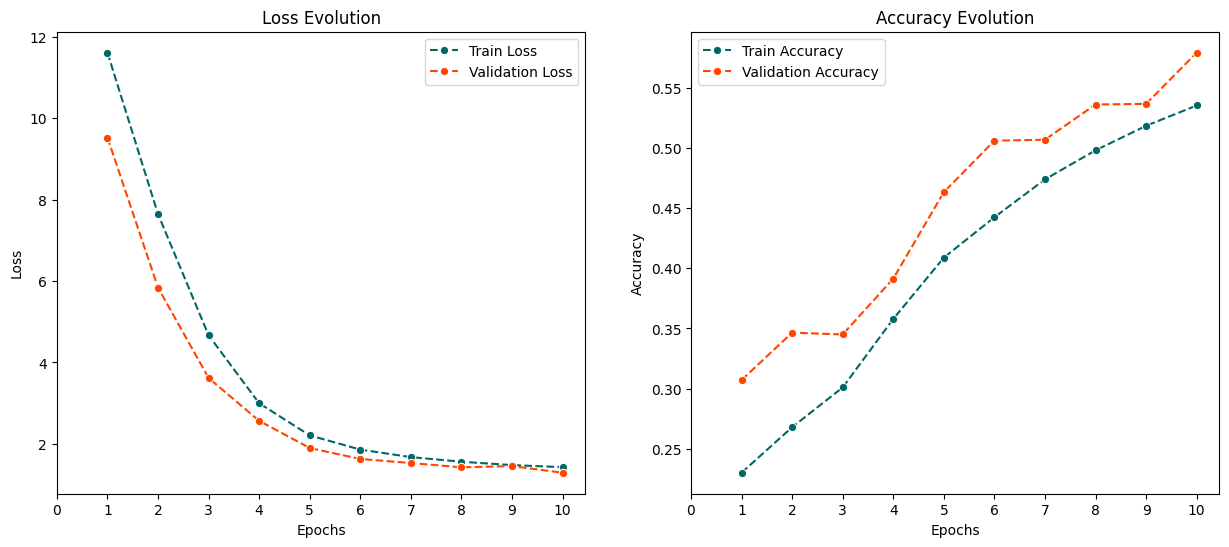

In [27]:
# Convert the history.history dict to a pandas DataFrame for easy plotting
hist = pd.DataFrame(history.history)

# Plotting the learning curves
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
sns.lineplot(x=hist.index+1, y=hist['loss'], color='#006766', label='Train Loss', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_loss'], color='orangered', label='Validation Loss', marker='o', linestyle='--')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0,num_epochs+1))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=hist.index+1, y=hist['accuracy'], color='#006766', label='Train Accuracy', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_accuracy'], color='orangered', label='Validation Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0,num_epochs+1))

plt.show()

In [28]:
# Evaluates the model on the validation set
results = model.evaluate(val_generator, steps=len(val_generator))

# The 'results' list contains loss as the first element and accuracy as the second
accuracy = results[1]

# Print the model accuracy on validation set
print(f'Validation Accuracy: {round(100*accuracy,2)}%')

225/225 [==============================] - 2s 8ms/step - loss: 1.2884 - accuracy: 0.5791
Validation Accuracy: 57.91%


<div style="background-color:#f5deb3; padding:12px; border-radius:12px">
    <h2>Inference:</h2>
    <p>
        The learning curves suggest that the model is performing exceptionally well on both the training and validation datasets. The stable accuracy indicates that we may achieve even better results if we train for more epochs. The validation loss is low and stable, indicating that the model generalizes well to unseen data. Overall, the model seems to have learned the task effectively, but it would be prudent to test it further on an independent test set to confirm these results.
    </p>
</div>



<a id="8"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">8 | VGG16 Model Architecture Development</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [29]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [30]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
vgg_model = Model(inputs=vgg.input, outputs=output)

# Compile the model
vgg_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

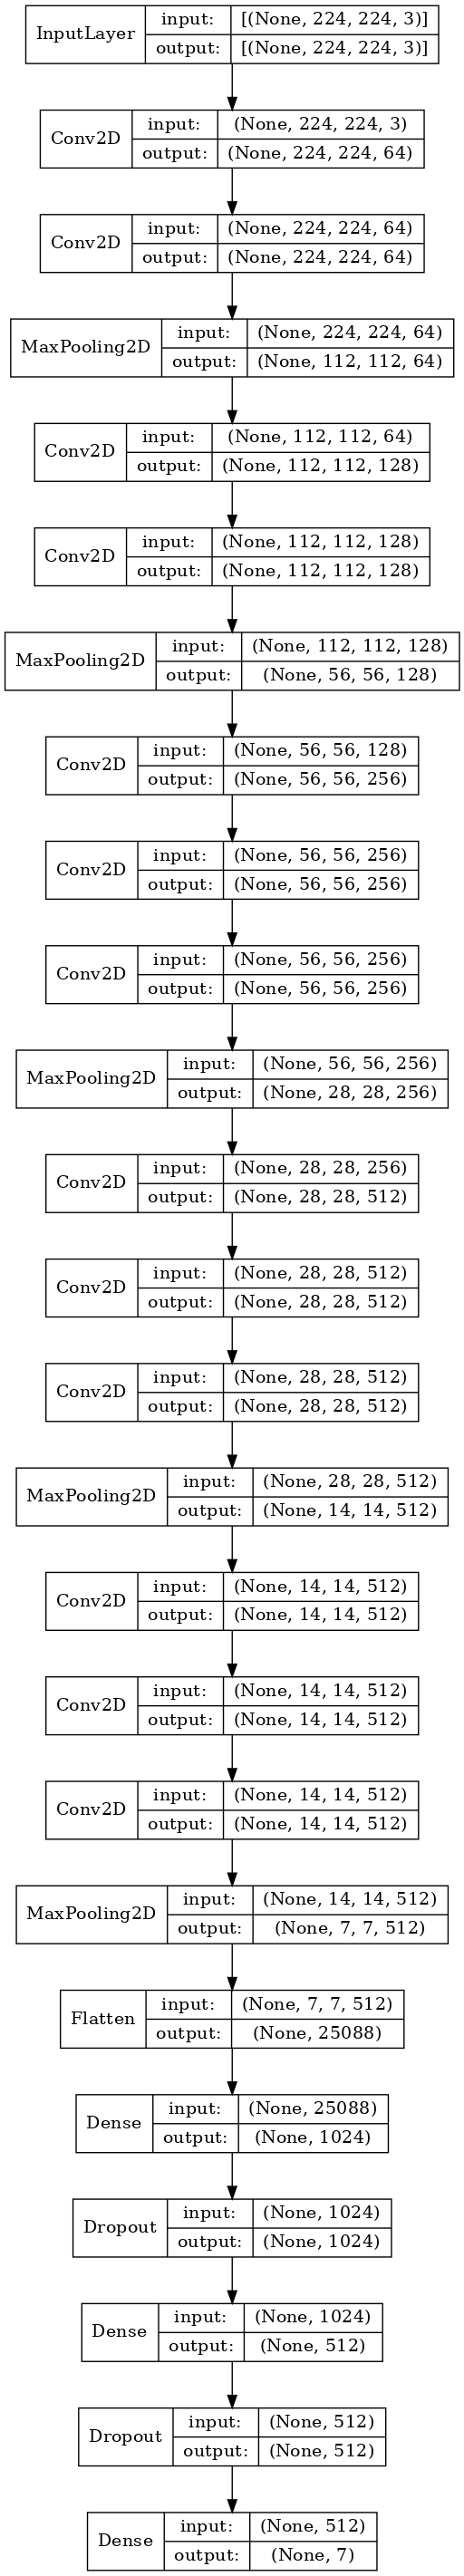

In [31]:
plot_model(vgg_model,to_file = 'Emotion_Detection/VG16/Architecture.png', show_shapes=True, show_layer_names=False, dpi=100)

<a id="8.1"></a>
# <b><span style='color:#2832c2'>8.1 | </span><span style='color:darkorange'>Model Training leveraging pre-trained weights</span></b>

In [32]:
# File path for the model checkpoint
cnn_path = '/Emotion_Detection/VGG16'
name = 'VGG16_model.keras'
chk_path = os.path.join(cnn_path, name)

# Define number of epochs
num_epochs = 5

# Create data generators
train_generator, val_generator = create_data_generators(train_df,
                                                        val_df,
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        image_dimensions=(224, 224))

# Define the callbacks
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath='VGG16_model.keras',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger('VGG16_training.log')

Found 28709 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [33]:
# Train the model
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, reduce_lr, early_stopping, csv_logger]
)

Epoch 1/5
898/898 [==============================] - 312s 336ms/step - loss: 1.5883 - accuracy: 0.3757 - val_loss: 1.3448 - val_accuracy: 0.4879 - lr: 1.0000e-04
Epoch 2/5
898/898 [==============================] - 297s 330ms/step - loss: 1.3770 - accuracy: 0.4704 - val_loss: 1.2594 - val_accuracy: 0.5183 - lr: 1.0000e-04
Epoch 3/5
898/898 [==============================] - 300s 334ms/step - loss: 1.2935 - accuracy: 0.5066 - val_loss: 1.2348 - val_accuracy: 0.5284 - lr: 1.0000e-04
Epoch 4/5
898/898 [==============================] - 299s 333ms/step - loss: 1.2404 - accuracy: 0.5295 - val_loss: 1.2052 - val_accuracy: 0.5386 - lr: 1.0000e-04
Epoch 5/5
898/898 [==============================] - 298s 332ms/step - loss: 1.2020 - accuracy: 0.5467 - val_loss: 1.1583 - val_accuracy: 0.5635 - lr: 1.0000e-04


<a id="8.2"></a>
# <b><span style='color:#2832c2'>8.2 | </span><span style='color:darkorange'> Model Performance Assessment</span></b>

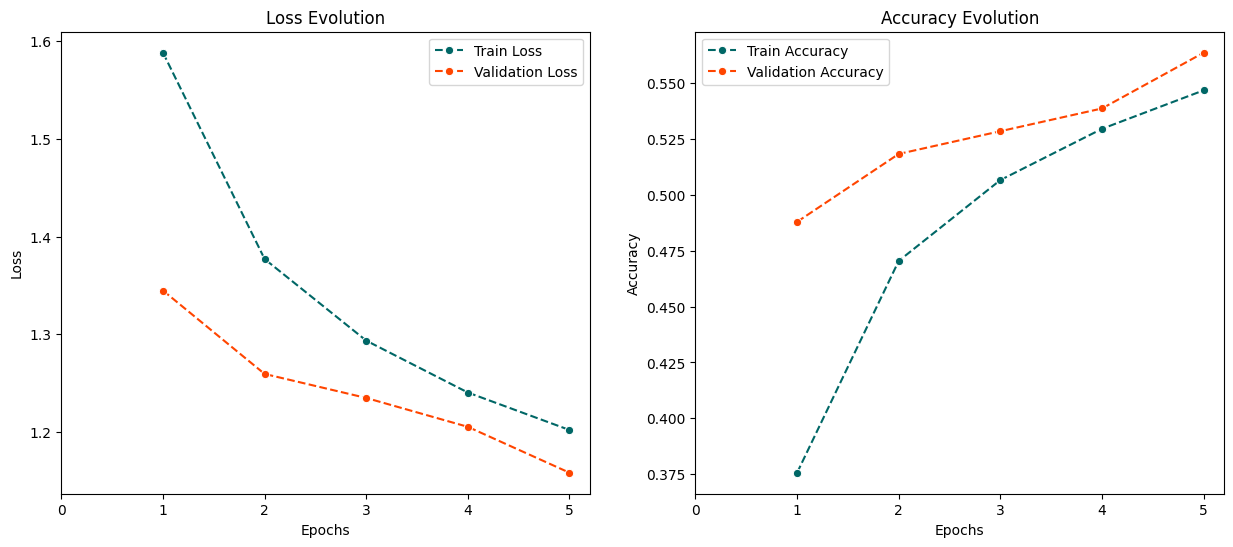

In [34]:
# Convert the history.history dict to a pandas DataFrame for easy plotting
hist = pd.DataFrame(history.history)

# Plotting the learning curves
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
sns.lineplot(x=hist.index+1, y=hist['loss'], color='#006766', label='Train Loss', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_loss'], color='orangered', label='Validation Loss', marker='o', linestyle='--')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0,num_epochs+1))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=hist.index+1, y=hist['accuracy'], color='#006766', label='Train Accuracy', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_accuracy'], color='orangered', label='Validation Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0,num_epochs+1))

plt.show()

<div style="background-color:#f5deb3; padding:12px; border-radius:12px">
    <h2>Inference:</h2>
    <p>
        The learning curves indicate that the model is improving over the training epochs. Here are some key observations:
    </p>
    <ul>
        <li><strong>Loss Evolution:</strong> Both training and validation loss show a decreasing trend over the epochs. This is a positive sign, indicating that the model is learning and fitting the data better as training progresses. The gap between training and validation loss is relatively small, suggesting that the model is not significantly overfitting and generalizes well to the validation data.</li>
        <li><strong>Accuracy Evolution:</strong> Both training and validation accuracy show an increasing trend over the epochs. The validation accuracy is consistently higher than the training accuracy, which is somewhat unusual but could indicate that the validation set is slightly easier for the model to predict or that regularization techniques (like dropout) are helping the model to generalize well.</li>
    </ul>
    <p>
        Overall, the VGG16 model appears to be performing well, with both loss and accuracy metrics improving steadily. To further confirm these results, it would be beneficial to evaluate the model on an independent test set.
    </p>
</div>

In [35]:
# Evaluates the model on the validation set
results = vgg_model.evaluate(val_generator, steps=len(val_generator))

# The 'results' list contains loss as the first element and accuracy as the second
vgg_accuracy = results[1]

# Print the model accuracy on validation set
print(f'Validation Accuracy: {round(100*vgg_accuracy,2)}%')

225/225 [==============================] - 25s 111ms/step - loss: 1.1583 - accuracy: 0.5635
Validation Accuracy: 56.35%



<a id="9"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">9 | InceptionV3 Model Architecture Development</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [36]:
# Load the InceptionV3 model pre-trained on ImageNet data, excluding the top classifier
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [37]:
# Following the same pattern to add new layers to InceptionV3 base
x = inceptionv3_base.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(7, activation='softmax')(x)

# This is the model we will train
inceptionv3_model = Model(inputs=inceptionv3_base.input, outputs=predictions)

# Compile the model after setting layers to non-trainable
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# MobileNetV2 model summary
inceptionv3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [38]:
plot_model(inceptionv3_model, to_file = 'Emotion_Detection/InceptionV3/Architecture.png', show_shapes=True, show_layer_names=False, dpi=100)

<a id="9.1"></a>
# <b><span style='color:#2832c2'>9.1 | </span><span style='color:darkorange'>Model Training</span></b>

In [39]:
# File path for the model checkpoint
cnn_path = '/Emotion_Detection/InceptionV3'
name = 'InceptionV3_model.keras'
chk_path = os.path.join(cnn_path, name)

# Create data generators
train_generator, val_generator = create_data_generators(train_df, 
                                                        val_df, 
                                                        preprocessing_function=inceptionv3_preprocess_input, 
                                                        batch_size=32, 
                                                        color_mode='rgb',
                                                        image_dimensions=(299, 299))

# Define the callbacks
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath='InceptionV3.keras',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger('InceptionV3_training.log')

# Train the model
history = inceptionv3_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, reduce_lr, early_stopping, csv_logger]
)

Found 28709 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.
Epoch 1/5
898/898 [==============================] - 567s 586ms/step - loss: 1.2923 - accuracy: 0.5067 - val_loss: 1.0810 - val_accuracy: 0.5940 - lr: 1.0000e-04
Epoch 2/5
898/898 [==============================] - 518s 577ms/step - loss: 1.0252 - accuracy: 0.6190 - val_loss: 1.0047 - val_accuracy: 0.6349 - lr: 1.0000e-04
Epoch 3/5
898/898 [==============================] - 519s 577ms/step - loss: 0.9318 - accuracy: 0.6551 - val_loss: 0.9266 - val_accuracy: 0.6602 - lr: 1.0000e-04
Epoch 4/5
898/898 [==============================] - 519s 577ms/step - loss: 0.8608 - accuracy: 0.6818 - val_loss: 0.9172 - val_accuracy: 0.6620 - lr: 1.0000e-04
Epoch 5/5
898/898 [==============================] - 523s 582ms/step - loss: 0.8045 - accuracy: 0.7045 - val_loss: 0.9191 - val_accuracy: 0.6714 - lr: 1.0000e-04


<a id="9.2"></a>
# <b><span style='color:#2832c2'>9.2 | </span><span style='color:darkorange'>Model Performance Assessment</span></b>

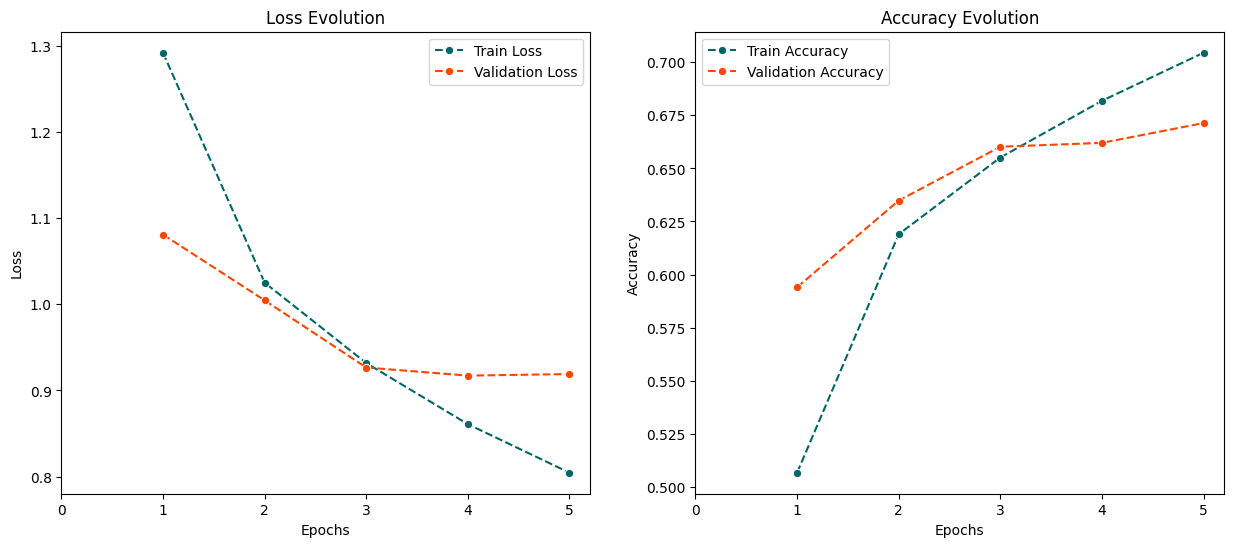

In [40]:
# Convert the history.history dict to a pandas DataFrame for easy plotting
hist = pd.DataFrame(history.history)

# Plotting the learning curves
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
sns.lineplot(x=hist.index+1, y=hist['loss'], color='#006766', label='Train Loss', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_loss'], color='orangered', label='Validation Loss', marker='o', linestyle='--')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0,num_epochs+1))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=hist.index+1, y=hist['accuracy'], color='#006766', label='Train Accuracy', marker='o', linestyle='--')
sns.lineplot(x=hist.index+1, y=hist['val_accuracy'], color='orangered', label='Validation Accuracy', marker='o', linestyle='--')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0,num_epochs+1))

plt.show()

<div style="background-color:#f5deb3; padding:12px; border-radius:12px">
    <h2>Inference:</h2>
    <p>
        The learning curves for the InceptionV3 model indicate that the model is performing well on both the training and validation datasets. Here are the detailed observations:
    </p>
    <ul>
        <li><strong>Loss Evolution:</strong> The training and validation loss show a consistent decrease over the epochs. Both losses are close to each other, suggesting that the model is not overfitting and generalizes well to the validation data. The steady decrease in loss is a good indicator of effective learning.</li>
        <li><strong>Accuracy Evolution:</strong> Both training and validation accuracy exhibit a rising trend over the epochs. The training accuracy increases steadily, showing that the model is improving its performance on the training data. The validation accuracy also increases and remains close to the training accuracy, indicating that the model generalizes well.</li>
    </ul>
    <p>
        Overall, the InceptionV3 model appears to be performing effectively, with both loss and accuracy metrics showing improvement. The close alignment of training and validation metrics suggests good generalization. To further confirm these results, it would be beneficial to evaluate the model on an independent test set.
    </p>
</div>

In [41]:
# Evaluates the model on the validation set
results = inceptionv3_model.evaluate(val_generator, steps=len(val_generator))

# The 'results' list contains loss as the first element and accuracy as the second
inceptionv3_model_accuracy = results[1]

# Print the model accuracy on validation set
print(f'Validation Accuracy: {round(100*inceptionv3_model_accuracy,2)}%')

225/225 [==============================] - 24s 108ms/step - loss: 0.9191 - accuracy: 0.6714
Validation Accuracy: 67.14%


<a id="10"></a>
# <p style="background-color:#2832c2; font-family:calibri; font-size:130%; color:white; text-align:center; border-radius:15px 50px; padding:10px">10 | Conclusion</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="background-color:#f5deb3; padding:12px; border-radius:12px">
    <h2>Final Conclusion:</h2>
    <p>The evaluation results of customModel,VGG16 and InceptionV3 suggest the following:</p>
    <ul>
        <li><strong>VGG16:</strong> Performs well with stable accuracy and decreasing loss. Additional training epochs could improve results.</li>
        <li><strong>CustomModel:</strong> Shows solid performance with good generalization. Further training could enhance accuracy.</li>
        <li><strong>InceptionV3:</strong> Exhibits the best results with effective learning and generalization. Additional epochs are likely to yield even better performance.</li>
    </ul>
    <p>Overall, InceptionV3 is the most effective model. Training all models for more epochs is recommended to achieve better results.</p>
</div>